# Forecasting

NOTES: Concatenate zero-day data with the target visit day. Try to predict the correct output.

In [190]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, roc_curve, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.multioutput import MultiOutputRegressor

from lib import data

pd.options.display.max_columns = None
sns.set()

In [192]:
TARGET_VISIT_DAY = 18 * 7

## Data Transformation

In [291]:
def group_transform(g):
    g['PANSS_TotalDelta'] = g.PANSS_Total - g.PANSS_Total.iloc[0]
    
    baseline = g[g.VisitDay == 0].mean().to_frame().T
    baseline = baseline.filter(regex="((P|N|G)\d+|Control|Treatment)").add_prefix('baseline_')

    baseline_rep = pd.DataFrame(
        baseline.values.repeat(len(g), axis=0),
        columns=baseline.columns,
        index=g.index
    )

    return g.join(baseline_rep)


def augment_df(df):
    df = df.copy()
    
    df['PositiveScore'] = df.filter(regex="P\d+").sum(axis=1)
    df['NegativeScore'] = df.filter(regex="N\d+").sum(axis=1)
    df['GeneralScore'] = df.filter(regex="G\d+").sum(axis=1)
    df['CompositeScore'] = df.PositiveScore - df.NegativeScore
    df['Control'] = df.TxGroup == 'Control'
    df['Treatment'] = df.TxGroup == 'Treatment'
    
    for study in df.Study.unique():
        df[f"Study{study}"] = df.Study == study

    return df.groupby('PatientID').apply(group_transform)


def get_dataset_a(df):
    df = augment_df(df)
    X = df.filter(regex="^PatientID|VisitDay|Study[A-E]|baseline_((P|N|G)\d+|Control|Treatment)$")
    y = df.filter(regex="^PANSS_Total$")
    
    return X, y


def get_dataset_b(df):
    df = augment_df(df)
    X = df.filter(regex="^PatientID|VisitDay|Study[A-E]|baseline_((P|N|G)\d+|Control|Treatment)$")
    y = df.filter(regex="^PANSS_TotalDelta$")
    
    return X, y


def get_dataset_c(df):
    df = augment_df(df)
    X = df.filter(regex="^PatientID|VisitDay|Study[A-E]|baseline_((P|N|G)\d+|Control|Treatment)$")
    y = df.filter(regex="(P|N|G)\d+")
    
    return X, y

## Linear Regression

In [314]:
train_data = data.read_train_data()
train_data = train_data[train_data.Study.isin({'C', 'D'})]
X, y = get_dataset_a(train_data)
X.head()

,PatientID,VisitDay,StudyC,StudyD,baseline_P1,baseline_P2,baseline_P3,baseline_P4,baseline_P5,baseline_P6,baseline_P7,baseline_N1,baseline_N2,baseline_N3,baseline_N4,baseline_N5,baseline_N6,baseline_N7,baseline_G1,baseline_G2,baseline_G3,baseline_G4,baseline_G5,baseline_G6,baseline_G7,baseline_G8,baseline_G9,baseline_G10,baseline_G11,baseline_G12,baseline_G13,baseline_G14,baseline_G15,baseline_G16,baseline_Control,baseline_Treatment
AssessmentiD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
301017,30001,0,True,False,3.0,4.0,4.0,1.0,1.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0
308004,30001,21,True,False,3.0,4.0,4.0,1.0,1.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0
304775,30001,28,True,False,3.0,4.0,4.0,1.0,1.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0
310369,30001,56,True,False,3.0,4.0,4.0,1.0,1.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0
313218,30001,84,True,False,3.0,4.0,4.0,1.0,1.0,3.0,2.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0


In [315]:
X_train, X_val, y_train, y_val = train_test_split(X.drop('PatientID', axis=1), y, test_size=0.2)

In [316]:
clf = LinearRegression().fit(X_train, y_train)
mean_squared_error(y_val.sum(axis=1), clf.predict(X_val).sum(axis=1))

160.6734773576878

In [317]:
mean_squared_error(y_train, clf.predict(X_train))

158.0478145017369

## Baseline XGBoost

In [318]:
eval_set = [(X_train, y_train), (X_val, y_val)]
params = {
    'max_depth': 5,
    'gamma': 10,
    'objective': 'reg:squarederror',
    'n_estimators': 400,
}
clf = xgb.XGBRegressor(**params).fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [320]:
pred = clf.predict(X_train)
mean_squared_error(y_train, pred)

33.64701469805866

In [319]:
pred = clf.predict(X_val)
mean_squared_error(y_val, pred)

55.88993651992656

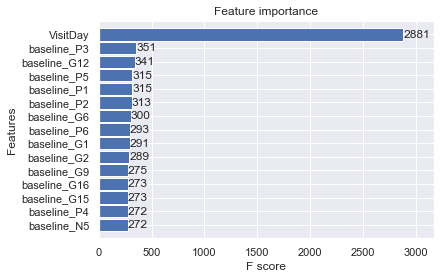

In [321]:
xgb.plot_importance(clf, height=0.9, max_num_features=15)

Text(0.5, 0, 'Number of estimators')

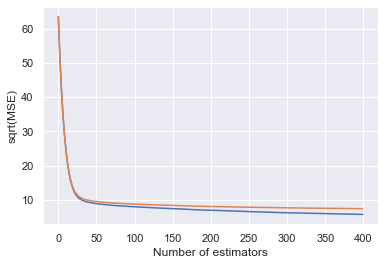

In [325]:
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(epochs)

fig, ax = plt.subplots()
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')

plt.ylabel('sqrt(MSE)')
plt.xlabel('Number of estimators')

## Delta regressor

In [326]:
train_data = data.read_train_data()
X, y = get_dataset_b(train_data)
X_train, X_val, y_train, y_val = train_test_split(X.drop('PatientID', axis=1), y, test_size=0.2)

In [327]:
eval_set = [(X_train, y_train), (X_val, y_val)]
clf = xgb.XGBRegressor(**params).fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [328]:
pred = clf.predict(X_train)
mean_squared_error(y_train, pred)

41.215119730062526

In [329]:
pred = clf.predict(X_val)
mean_squared_error(y_val, pred)

65.42664568996695

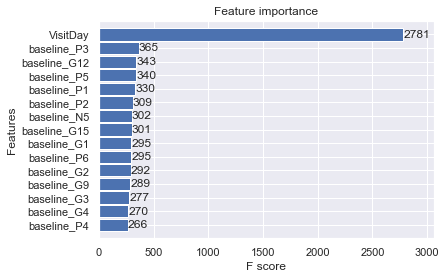

In [330]:
xgb.plot_importance(clf, height=0.9, max_num_features=15)

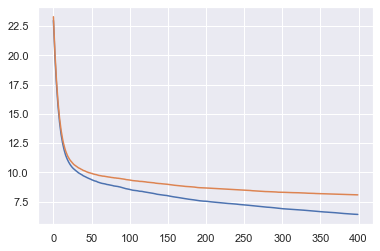

In [331]:
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(epochs)

fig, ax = plt.subplots()
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')

## Training final model

In [61]:
train_df = data.read_train_data().drop(['LeadStatus'], axis=1)
test_df = data.read_test_data()

In [62]:
df = pd.concat([train_df, test_df])
X, y = get_dataset(df)

In [63]:
clf = xgb.XGBRegressor(**params).fit(X.drop('PatientID', axis=1), y, verbose=False)

In [64]:
def transform_test_group(g):
    new_row = g.iloc[[0]].copy()
    new_row.VisitDay = TARGET_VISIT_DAY
    return new_row


def transform_test_set(X):
    dg = X.groupby('PatientID', as_index=False, squeeze=True)
    return dg.apply(transform_test_group)

In [65]:
X_tf = transform_test_set(X)
X_tf.head()

,,PatientID,VisitDay,baseline_P1,baseline_P2,baseline_P3,baseline_P4,baseline_P5,baseline_P6,baseline_P7,baseline_N1,baseline_N2,baseline_N3,baseline_N4,baseline_N5,baseline_N6,baseline_N7,baseline_G1,baseline_G2,baseline_G3,baseline_G4,baseline_G5,baseline_G6,baseline_G7,baseline_G8,baseline_G9,baseline_G10,baseline_G11,baseline_G12,baseline_G13,baseline_G14,baseline_G15,baseline_G16,baseline_Tx
,AssessmentiD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,100679,10001,126,5.0,5.0,5.0,3.0,4.0,5.0,3.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,4.0,4.0,4.0,1.0,4.0,1.0,3.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,0.0
1,100597,10002,126,5.0,5.0,5.0,1.0,2.0,5.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,3.0,1.0,4.0,1.0,3.0,1.0,3.0,1.0,1.0,5.0,2.0,1.0,3.0,3.0,3.0,3.0,5.0,0.0
2,101799,10003,126,5.0,5.0,5.0,3.0,4.0,5.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,3.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,1.0
3,101826,10004,126,5.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,4.0,3.0,4.0,4.0,5.0,3.0,3.0,1.0,3.0,1.0,1.0,4.0,4.0,1.0,5.0,1.0,3.0,3.0,3.0,1.0,4.0,4.0,1.0
4,101530,10005,126,5.0,5.0,5.0,1.0,2.0,5.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,2.0,5.0,1.0,4.0,3.0,1.0,3.0,3.0,5.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0


In [66]:
sample_df = pd.read_csv('submission/sample_submission_PANSS.csv')
test_df = (
    pd.merge(sample_df.drop('PANSS_Total', axis=1), X_tf, on="PatientID", how="inner")
    .drop('PatientID', axis=1)
)

In [67]:
test_df.head()

,VisitDay,baseline_P1,baseline_P2,baseline_P3,baseline_P4,baseline_P5,baseline_P6,baseline_P7,baseline_N1,baseline_N2,baseline_N3,baseline_N4,baseline_N5,baseline_N6,baseline_N7,baseline_G1,baseline_G2,baseline_G3,baseline_G4,baseline_G5,baseline_G6,baseline_G7,baseline_G8,baseline_G9,baseline_G10,baseline_G11,baseline_G12,baseline_G13,baseline_G14,baseline_G15,baseline_G16,baseline_Tx
0,126,3.0,4.0,1.0,3.0,2.0,4.0,1.0,3.0,3.0,3.0,2.0,4.0,4.0,5.0,4.0,4.0,1.0,3.0,3.0,1.0,1.0,2.0,3.0,1.0,4.0,3.0,3.0,1.0,3.0,3.0,1.0
1,126,2.0,3.0,2.0,3.0,1.0,3.0,2.0,5.0,6.0,5.0,5.0,3.0,2.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,4.0,2.0,3.0,3.0,1.0
2,126,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,5.0,3.0,5.0,1.0,3.0,2.0,0.0
3,126,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,4.0,3.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0,1.0
4,126,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,2.5,1.0,1.0,1.0,1.0


In [68]:
pred = pd.DataFrame({'PatientID': sample_df.PatientID, 'PANSS_Total': clf.predict(test_df)})
pred.to_csv('submission/PANSS.csv', index=False)

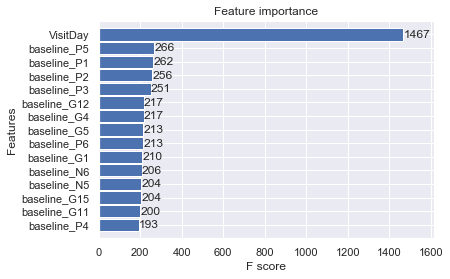

In [69]:
xgb.plot_importance(clf, height=0.9, max_num_features=15)